In [1]:
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from brainflow.board_shim import BoardShim, BrainFlowInputParams, LogLevels, BoardIds
from brainflow.data_filter import DataFilter, WindowOperations, DetrendOperations, NoiseTypes, WaveletTypes

import scipy.signal as ss

import argparse
import time

from brainflow.board_shim import BoardShim, BrainFlowInputParams, LogLevels
from brainflow.data_filter import DataFilter
from brainflow.ml_model import MLModel, BrainFlowMetrics, BrainFlowClassifiers, BrainFlowModelParams

### useful links
#### [simple brainflow examples](https://brainflow.readthedocs.io/en/stable/Examples.html)
#### [brainflow github](https://github.com/brainflow-dev/brainflow) look under python_package/examples also
#### [MNE](https://mne.tools/stable/index.html) could send data to this and use to process [example here](https://github.com/brainflow-dev/brainflow/blob/master/python_package/examples/tests/brainflow_to_mne.py)

In [2]:
BoardShim.enable_dev_board_logger()

# use synthetic board for demo
params = BrainFlowInputParams()
board_id = BoardIds.SYNTHETIC_BOARD.value
board_descr = BoardShim.get_board_descr(board_id)
sampling_rate = int(board_descr['sampling_rate'])
board = BoardShim(board_id, params)
board.prepare_session()
board.start_stream()

BoardShim.log_message(LogLevels.LEVEL_INFO.value, 'start sleeping in the main thread')
time.sleep(10)

data = board.get_board_data()
board.stop_stream()
board.release_session()

[2025-03-04 11:30:47.853] [board_logger] [info] incoming json: {
    "file": "",
    "file_anc": "",
    "file_aux": "",
    "ip_address": "",
    "ip_address_anc": "",
    "ip_address_aux": "",
    "ip_port": 0,
    "ip_port_anc": 0,
    "ip_port_aux": 0,
    "ip_protocol": 0,
    "mac_address": "",
    "master_board": -100,
    "other_info": "",
    "serial_number": "",
    "serial_port": "",
    "timeout": 0
}
[2025-03-04 11:30:47.853] [board_logger] [trace] Board object created -1
[2025-03-04 11:30:47.854] [board_logger] [info] start sleeping in the main thread


In [3]:
board_descr

{'accel_channels': [17, 18, 19],
 'battery_channel': 29,
 'ecg_channels': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 'eda_channels': [23],
 'eeg_channels': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 'eeg_names': 'Fz,C3,Cz,C4,Pz,PO7,Oz,PO8,F5,F7,F3,F1,F2,F4,F6,F8',
 'emg_channels': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 'eog_channels': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 'gyro_channels': [20, 21, 22],
 'marker_channel': 31,
 'name': 'Synthetic',
 'num_rows': 32,
 'package_num_channel': 0,
 'ppg_channels': [24, 25],
 'resistance_channels': [27, 28],
 'sampling_rate': 250,
 'temperature_channels': [26],
 'timestamp_channel': 30}

In [4]:
# can load data into df
df = pd.DataFrame(np.transpose(data))
df

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.0,11.778811,29.200811,50.611691,80.110594,104.442779,127.096890,296.636154,389.545143,487.567182,...,0.975048,1.049110,466.278803,230068.874248,36.607014,944.545761,1060.411568,86.558280,1.741109e+09,0.0
1,1.0,13.384704,35.621921,64.202401,90.419068,118.152397,127.786163,323.361122,363.280523,303.991342,...,0.872593,1.013845,526.180202,248902.146469,36.601205,1042.831312,978.998218,93.305027,1.741109e+09,0.0
2,2.0,15.183433,38.869241,71.506822,102.756071,108.110851,124.412922,94.565513,64.188779,21.897549,...,0.859112,1.076477,504.682697,250723.470134,36.608033,976.722405,952.826107,87.020549,1.741109e+09,0.0
3,3.0,16.573107,43.173914,75.742477,90.472071,74.446982,49.153893,24.426754,-9.640994,-24.160157,...,0.866859,0.953191,532.849733,269429.016107,36.602306,990.781856,1058.593438,83.159681,1.741109e+09,0.0
4,4.0,18.339991,47.470909,65.758158,67.917346,32.786535,3.626353,-41.290493,18.282078,52.362737,...,0.907822,1.083478,525.957398,234616.714559,36.605905,980.107200,966.377571,95.237546,1.741109e+09,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,192.0,4.748084,1.061928,-6.131080,-22.435251,-31.210473,1.702953,-7.861849,36.236940,67.444152,...,0.840152,0.984734,480.252713,276982.616090,36.608655,986.239667,1034.295749,99.849942,1.741109e+09,0.0
2497,193.0,6.338641,8.708562,3.208531,2.692063,-26.238248,-14.813696,-29.014453,-77.018433,13.000371,...,0.851764,1.078719,452.902698,234772.420230,36.593501,987.153988,917.377821,89.729350,1.741109e+09,0.0
2498,194.0,8.197271,14.440904,19.259226,19.794722,20.366660,23.878323,33.019834,34.921177,-30.606142,...,0.969734,0.962249,478.081113,277394.098086,36.594327,1059.315165,954.082953,91.950200,1.741109e+09,0.0
2499,195.0,10.000000,21.281180,34.356092,48.793669,65.144088,75.166407,89.967309,120.278564,132.061405,...,0.825455,1.065981,502.913202,261716.596782,36.606882,1018.846909,1062.264833,89.753655,1.741109e+09,0.0


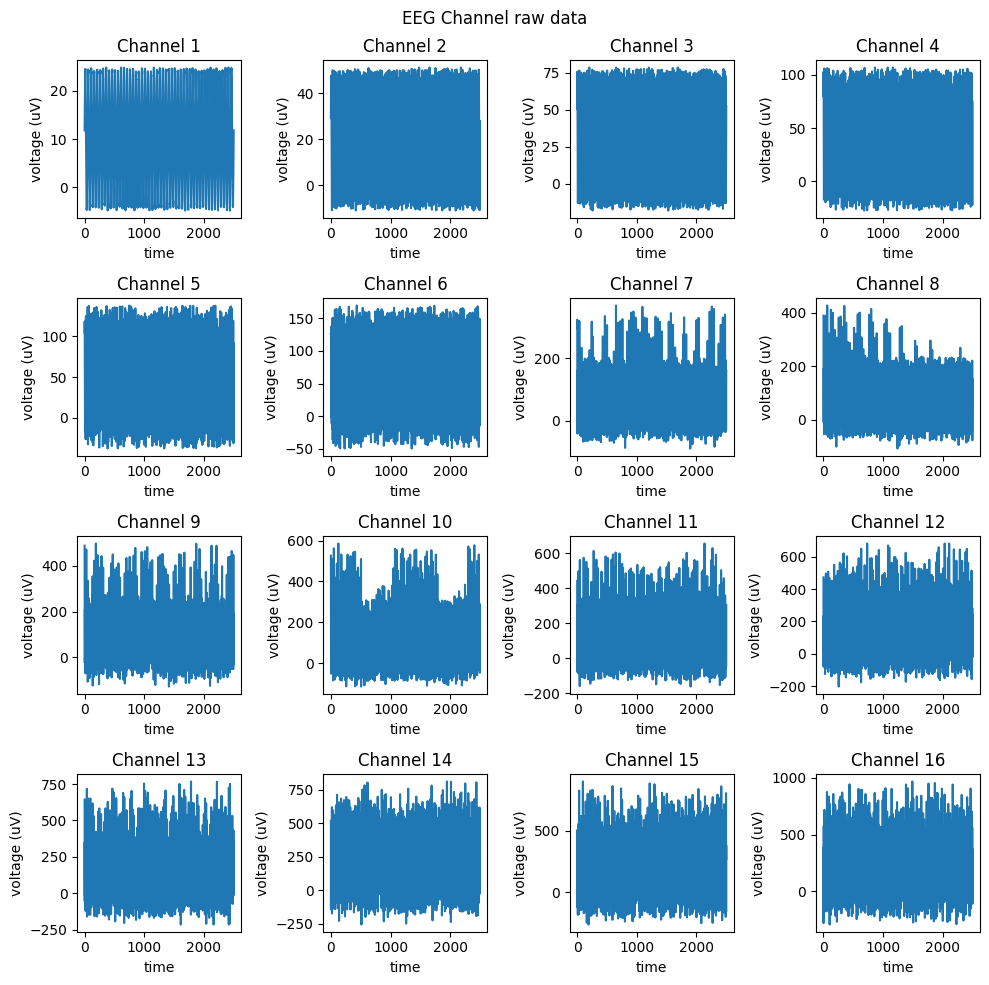

In [5]:
eeg_channels = board_descr['eeg_channels']
num_channels = len(eeg_channels)

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.ravel()
fig.suptitle("EEG Channel raw data")

for i, channel in enumerate(eeg_channels):
    axes[i].plot(data[channel])
    axes[i].set_title(f"Channel {channel}")
    axes[i].set_xlabel("time")
    axes[i].set_ylabel("voltage (uV)") #probs what our voltage unit will be 

plt.tight_layout()
plt.show()

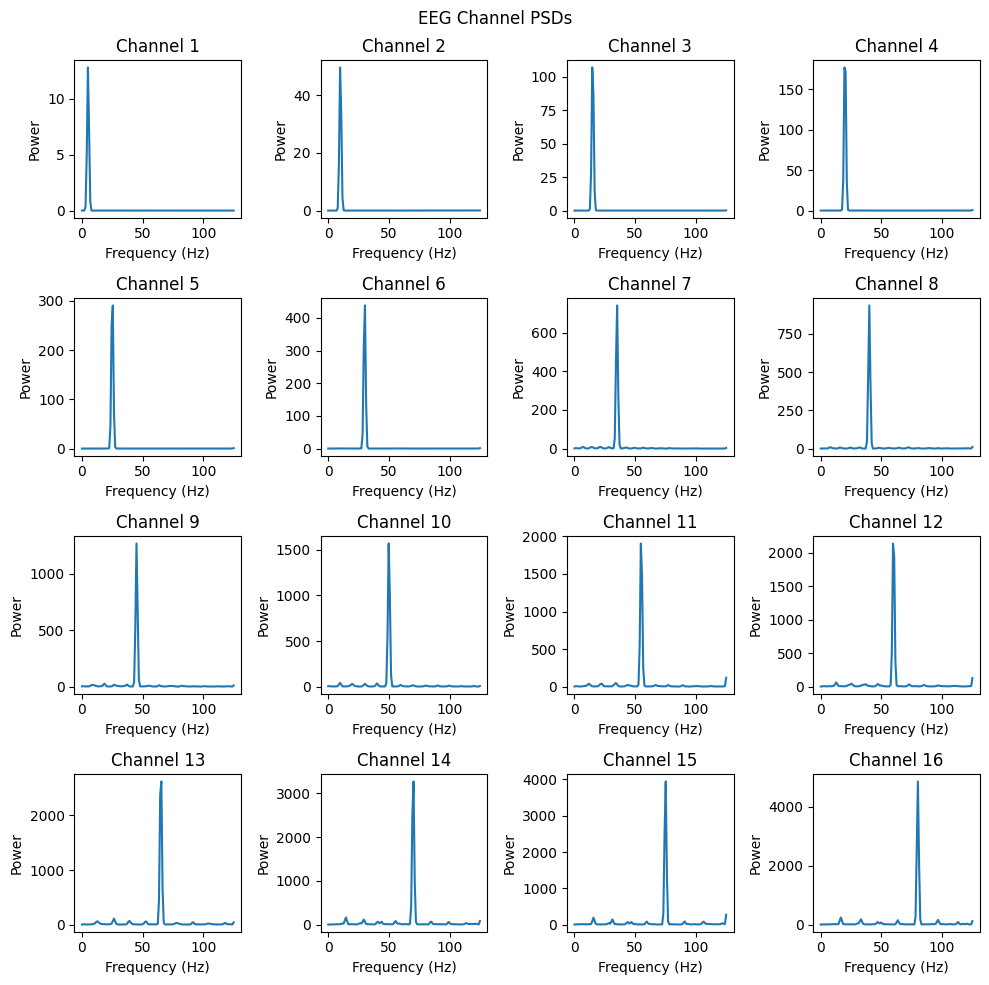

In [6]:
nfft = DataFilter.get_nearest_power_of_two(sampling_rate)

fig, axes = plt.subplots(4, 4, figsize=(10, 10)) 
axes = axes.ravel()
fig.suptitle("EEG Channel PSDs")

for i, channel in enumerate(eeg_channels):
    DataFilter.detrend(data[channel], DetrendOperations.LINEAR.value) # i think this overwrites the data[channel] by default kinda like pandas inplace 
    power, hz = DataFilter.get_psd_welch(data[channel], nfft, nfft // 2, sampling_rate, WindowOperations.BLACKMAN_HARRIS.value)
    
    axes[i].plot(hz, power)
    axes[i].set_title(f"Channel {channel}")
    axes[i].set_xlabel("Frequency (Hz)")
    axes[i].set_ylabel("Power")

plt.tight_layout()
plt.show()


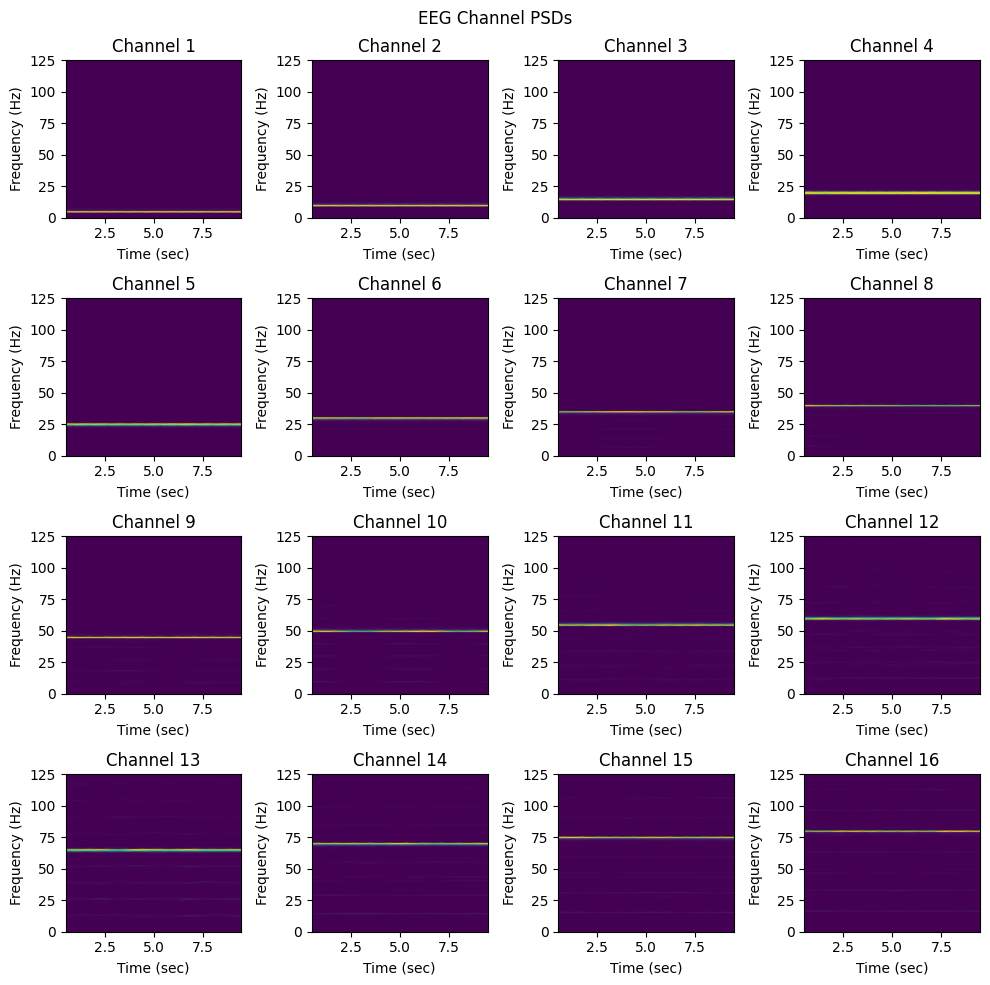

In [7]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10)) 
axes = axes.ravel()
fig.suptitle("EEG Channel PSDs")

for i, channel in enumerate(eeg_channels):
    
    # could replace with Pywavelet
    f, t, Sxx = ss.spectrogram(data[channel],sampling_rate)

    axes[i].pcolormesh(t, f, Sxx, shading='gouraud')
    axes[i].set_title(f"Channel {channel}")
    axes[i].set_ylabel('Frequency (Hz)')
    axes[i].set_xlabel('Time (sec)')
    

plt.tight_layout()
plt.show()


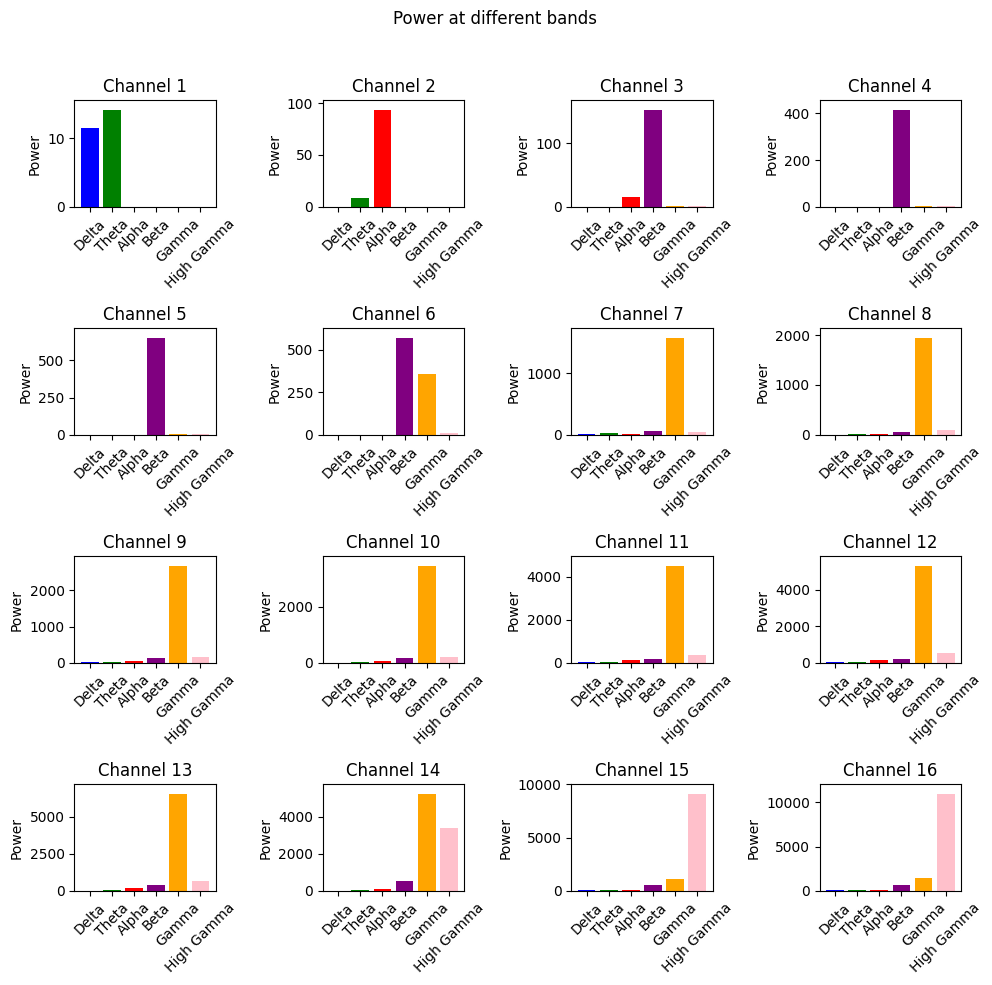

In [8]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.ravel()
fig.suptitle("Power at different bands")

for i, channel in enumerate(eeg_channels):
    psd = DataFilter.get_psd_welch(data[channel], nfft, nfft // 2, sampling_rate, WindowOperations.BLACKMAN_HARRIS.value)

    # Calculate band powers for different frequency bands
    band_power_delta = DataFilter.get_band_power(psd, 0.01, 4)
    band_power_theta = DataFilter.get_band_power(psd, 4, 8)
    band_power_alpha = DataFilter.get_band_power(psd, 8.0, 13.0)
    band_power_beta = DataFilter.get_band_power(psd, 14.0, 30.0)
    band_power_gamma = DataFilter.get_band_power(psd, 30, 70.0)
    band_power_high_gamma = DataFilter.get_band_power(psd, 70, 200)

    # Create a bar plot for the power at different bands
    band_powers = [band_power_delta, band_power_theta, band_power_alpha, band_power_beta, band_power_gamma, band_power_high_gamma]
    bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma']
    
    # Plot bars
    axes[i].bar(bands, band_powers, color=['blue', 'green', 'red', 'purple', 'orange', 'pink'])
    axes[i].set_title(channel)
    axes[i].set_title(f"Channel {channel}")
    axes[i].set_ylabel('Power')
    axes[i].set_ylim(0, max(band_powers) * 1.1)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust spacing to avoid overlap with the suptitle
plt.show()


### could use these metrics to find out if they are focused or not. 

In [9]:
# calculate avg and stddev of BandPowers 
# across all channels, bands are 1-4,4-8,8-13,13-30,30-50
bands = DataFilter.get_avg_band_powers(data, eeg_channels, sampling_rate, True)
print(bands[0])
feature_vector = bands[0]

mindfulness_params = BrainFlowModelParams(BrainFlowMetrics.MINDFULNESS.value,
                                            BrainFlowClassifiers.DEFAULT_CLASSIFIER.value)

# mindfulness is the focus metric 
mindfulness = MLModel(mindfulness_params)
mindfulness.prepare()
print('Mindfulness: %s' % str(mindfulness.predict(feature_vector)))
mindfulness.release()

# restfulness is the relaxation metric 
restfulness_params = BrainFlowModelParams(BrainFlowMetrics.RESTFULNESS.value,
                                            BrainFlowClassifiers.DEFAULT_CLASSIFIER.value)
restfulness = MLModel(restfulness_params)
restfulness.prepare()
print('Restfulness: %s' % str(restfulness.predict(feature_vector)))
restfulness.release()

[0.00760848 0.02402137 0.07865058 0.45588749 0.43383208]
Mindfulness: [1.]
Restfulness: [1.0619905e-10]
Mindfulness: [1.]
Restfulness: [1.0619905e-10]


### this has all been processing saved data. The project will actually be decoding in real time. So we have a few things to do 
#### 1) make sure we can read in data from our openBCI device 
* ##### start with trying to bring in recorded data and then try real time.
* ##### is our recording device good enough to show see if someone is focused.
#### 3) see if we can find any info about the focus and relaxtion metric. Is this a good metric for us to use?
#### 4) is the processing in brainflow good enough?
#### 5) Come up with ideas for what to show the user when they are focused